In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_ODT_sequence_new.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
# working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\repump"
;

In [2]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

In [3]:
using MAT

size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_20240124\\intensity.mat"
size_file = matread(size_file_path);

numbers_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_20240124\\intensity_numbers.mat"
numbers_file = matread(numbers_file_path);
 
temperature_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_Temperature_20240130\\temperatures.mat"
temperature_file = matread(temperature_file_path);

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\IntensityScan_20240124\\simulations.mat";

In [4]:
widths_x = size_file["widths_x"];
d_widths_x = size_file["widths_errors_x"];
widths_y = size_file["widths_y"];
d_widths_y = size_file["widths_errors_y"];

data_size = (widths_x.^2 .* widths_y).^(1/3)
d_data_size = sqrt.((2/3 .* d_widths_x ./ widths_x).^2 + (1/3 .* d_widths_y ./ widths_y).^2) .* data_size

data_signal = numbers_file["ampx1"];
d_data_signal = numbers_file["ampx1_errors"];

data_temperature = real.(temperature_file["temps"]);
d_data_temperature = real.(temperature_file["temp_errors"]);

voltages = size_file["all_params"]'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.3
 0.5
 0.7
 0.9
 1.1
 1.3
 1.5
 1.7
 1.9
 2.1

In [8]:
saving_path = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity2000.jl"

"C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity2000.jl"

In [9]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end

temp = @with_unit 1.00 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 

s2 = 0.0; Δ2 = 0.0; B_gradient = 75; ramp_time = 4e-3

detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)

intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4
;


results_list = []

for intensity_voltage in voltages
    power_total = intensity_voltage * 13.1 # mW

    p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
    p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
    p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

    s1 = 2 * p1 / (π * 0.5^2) / 3.4
    s3 = 2 * p3 / (π * 0.5^2) / 3.4
    s4 = 2 * p4 / (π * 0.5^2) / 3.4

    @printf("intensity voltage = %.1f V", intensity_voltage)
    blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 2000,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(1e6), FC_mainline=0.95,
                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0,0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3)




    sequence = [blue_MOT_params]
    durations = [ramp_time + 1e-3]
    generate_sequence!(sequence, durations)

    test_i = log_test_info(working_dir,1,blue_MOT_params)
    @time results = simulate_particles_ODT(package, package_A, sequence, variable_budget=true);
    
    push!(results_list, results)
    
    serialize(saving_path, results_list)

    @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    
    println()
    println()
end

intensity voltage = 0.3 V

Progress: 100%|█████████████████████████████████████████| Time: 0:31:08


1868.966472 seconds (28.14 M allocations: 2.226 GiB, 0.05% gc time, 15.90% compilation time: <1% of which was recompilation)
Survival: 1727 / 2000
goodness = 0.50

intensity voltage = 0.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:34:52


2092.869086 seconds (3.38 M allocations: 692.714 MiB, 0.01% gc time)
Survival: 1936 / 2000
goodness = 0.60

intensity voltage = 0.7 V

Progress: 100%|█████████████████████████████████████████| Time: 0:37:09


2229.473049 seconds (3.39 M allocations: 693.830 MiB, 0.00% gc time)
Survival: 1964 / 2000
goodness = 0.59

intensity voltage = 0.9 V

Progress: 100%|█████████████████████████████████████████| Time: 0:40:28


2428.599685 seconds (3.40 M allocations: 694.271 MiB, 0.00% gc time)
Survival: 1973 / 2000
goodness = 0.56

intensity voltage = 1.1 V

Progress: 100%|█████████████████████████████████████████| Time: 0:41:25


2485.186438 seconds (3.40 M allocations: 694.759 MiB, 0.00% gc time)
Survival: 1967 / 2000
goodness = 0.52

intensity voltage = 1.3 V

Progress: 100%|█████████████████████████████████████████| Time: 0:42:17


2537.328194 seconds (3.40 M allocations: 693.992 MiB, 0.00% gc time)
Survival: 1966 / 2000
goodness = 0.49

intensity voltage = 1.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:43:57

2637.276737 seconds (3.41 M allocations: 694.556 MiB, 0.00% gc time)


Survival: 1948 / 2000
goodness = 0.47

intensity voltage = 1.7 V

Progress: 100%|█████████████████████████████████████████| Time: 0:44:12


2652.956079 seconds (3.41 M allocations: 694.919 MiB, 0.00% gc time)
Survival: 1970 / 2000
goodness = 0.43

intensity voltage = 1.9 V

2683.955741 seconds (3.40 M allocations: 694.390 MiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:44:43


Survival: 1960 / 2000
goodness = 0.41

intensity voltage = 2.1 V

Progress: 100%|█████████████████████████████████████████| Time: 0:43:35


2615.933007 seconds (3.39 M allocations: 693.781 MiB, 0.01% gc time)
Survival: 1965 / 2000
goodness = 0.39



In [10]:
# serialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_single_det2000.jl", results_list)

In [5]:
results_list = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity2000.jl");
results_list_imperfection = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_imperfection2000.jl");

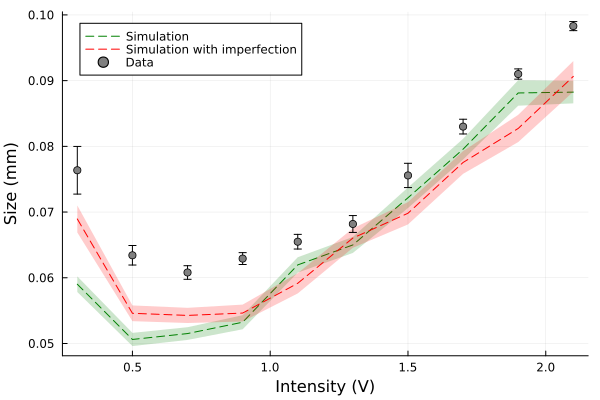

In [6]:
sizes = []
size_errors = []
for results in results_list[1:end]
    size, error = bootstrap_size_fit(results; iter=100)
    push!(sizes, size)
    push!(size_errors, error)
end

plot(voltages, sizes,color="green",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

sizes1 = []
size1_errors = []
for results in results_list_imperfection[1:end]
    size, error = bootstrap_size_fit(results; iter=100)
    push!(sizes1, size)
    push!(size1_errors, error)
end

plot!(voltages, sizes1,color="red",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation with imperfection",
ribbon=(size1_errors, size1_errors),fc=:red,fa=0.2)

scatter!(voltages, data_size, yerr=d_data_size, label="Data", color="gray")

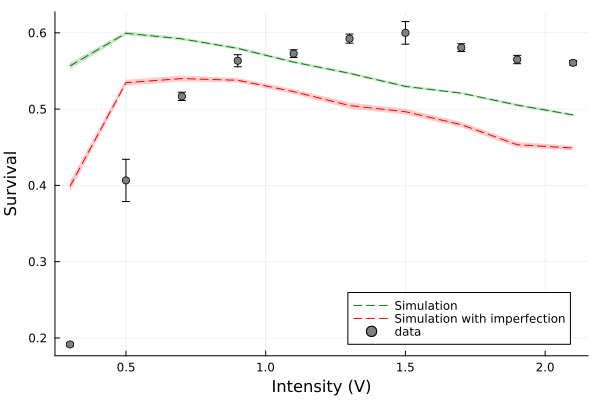

In [7]:
signals = []
signal_errors = []

for results in results_list[1:end]
    signal, error = bootstrap_survival(results, iter=100)
    push!(signals, signal)
    push!(signal_errors, error)
end
    
plot(voltages, signals,color="green", linestyle=:dash, xlabel="Intensity (V)", ylabel="Survival",label="Simulation",
ribbon=(signal_errors, signal_errors),fc=:green,fa=0.2)



signals1 = []
signal1_errors = []
for results in results_list_imperfection[1:end]
    signal1, error = bootstrap_survival(results; iter=100)
    push!(signals1, signal1)
    push!(signal1_errors, error)
end

plot!(voltages, signals1,color="red",linestyle=:dash, label="Simulation with imperfection",
ribbon=(signal1_errors, signal1_errors),fc=:red,fa=0.2)
scatter!(voltages, data_signal./maximum(data_signal)*0.6, yerr=d_data_signal, color="gray", label="data")

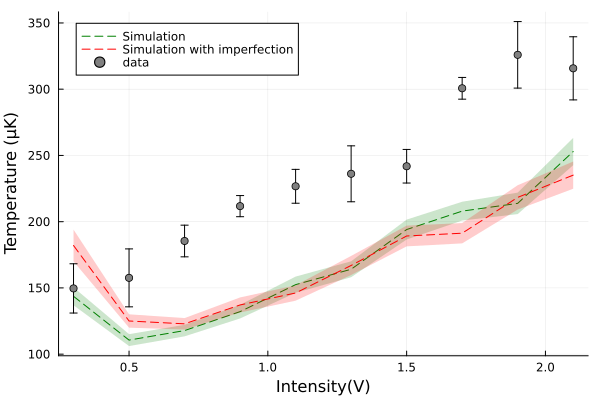

In [8]:
temperatures = []
temperature_errors = []
t_end = 5e-3

for results in results_list[1:end]
    temp, error = bootstrap_temperature_fit(results, iter=100)
    push!(temperatures, temp)
    push!(temperature_errors, error)
end
    
plot(voltages, temperatures,color="green",linestyle=:dash, xlabel="Intensity(V)", ylabel="Temperature (μK)",label="Simulation",
ribbon=(temperature_errors, temperature_errors),fc=:green,fa=0.2)



temperatures1 = []
temperature1_errors = []
for results in results_list_imperfection[1:end]
    temp, error = bootstrap_temperature_fit(results; iter=100)
    push!(temperatures1, temp)
    push!(temperature1_errors, error)
end

plot!(voltages, temperatures1,color="red",linestyle=:dash, label="Simulation with imperfection",
ribbon=(temperature1_errors, temperature1_errors),fc=:red,fa=0.2)


scatter!(voltages, data_temperature.*1e6, yerr=d_data_temperature.*1e6, color="gray", label="data")

In [10]:
file = matopen(simulation_file_path, "w")
write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_temperatures", temperatures)
write(file, "simulation_temperature_errors", temperature_errors)

write(file, "simulation_sizes_imperfection", sizes1)
write(file, "simulation_size_errors_imperfection", size1_errors)

write(file, "simulation_signals_imperfection", signals1)
write(file, "simulation_signal_errors_imperfection", signal1_errors)

write(file, "simulation_temperatures_imperfection", temperatures1)
write(file, "simulation_temperature_errors_imperfection", temperature1_errors)
close(file);